In [4]:
from d_heap import DWayHeap
from kdtree import _Node, KdTree, Point

In [2]:
heap = DWayHeap(branching_factor = 2)
heap.insert(0, 5) #value, priority
heap.insert(1, 20)

print(heap.peek_priority())
while not heap.is_empty():
  print(heap.top())

20
1
0


In [5]:
from os import close
class NodeChild(_Node):

  @property
  def dim(self):
      """Índice de la dimensión de comparación en este nodo."""
      if self._K is None or self._K == 0:
          raise ValueError("Dimensionalidad del nodo _K no establecida o es cero.")
      return self._depth % self._K

  def add(self, point_to_add):
    """Añade un punto a este subárbol."""
    if self.isEmpty():
      # Este nodo vacío se convierte en una hoja.
      self._point = point_to_add
      self._left = _Node.Empty(point_to_add.dimensionality, self._depth + 1)
      self._right = _Node.Empty(point_to_add.dimensionality, self._depth + 1)
      self._size = 1
      if self._K is None:
        self._K = point_to_add.dimensionality
        return True

    if self._point == point_to_add:
      return False  # El punto ya existe.

    current_dim = self.dim
    coord_to_add = point_to_add.coordinate(current_dim)
    coord_node = self._point.coordinate(current_dim)

    added = False
    if coord_to_add < coord_node:
      added = self._left.add(point_to_add)
    else:
      added = self._right.add(point_to_add)
    if added:
      self._size += 1
    return added

  def nearestNeighbour(self, target_point, current_nn=None, current_nn_dist=float('inf')):
      """Busca el vecino más cercano recursivamente."""
      if self.isEmpty():
          return current_nn, current_nn_dist

      dist_to_current = self._point.distanceTo(target_point)
      if dist_to_current < current_nn_dist:
          current_nn_dist = dist_to_current
          current_nn = self._point

      current_dim_val = self.dim
      node_coord = self._point.coordinate(current_dim_val)
      target_coord = target_point.coordinate(current_dim_val)

      if target_coord < node_coord:
          closest_branch = self._left
          further_branch = self._right
      else:
          closest_branch = self._right
          further_branch = self._left

      if closest_branch:
          current_nn, current_nn_dist = closest_branch.nearestNeighbour(target_point, current_nn, current_nn_dist)

      # Comprueba si la otra rama podría tener un punto más cercano.
      if abs(target_coord - node_coord) < current_nn_dist:
          if further_branch:
              current_nn, current_nn_dist = further_branch.nearestNeighbour(target_point, current_nn, current_nn_dist)

      return current_nn, current_nn_dist



In [6]:
class KdTreeChild(KdTree):
  def add(self, point):
    """Añade un punto al árbol."""
    if not isinstance(point, Point):
        raise TypeError(ERROR_MSG_PARAM_INVALID_POINT)

    if self._K is None:  # Primer punto, define K.
        self._K = point.dimensionality
        self._root._K = self._K
        added = self._root.add(point)
    else:
        Point.validatePoint(point, self.dimensionality, 'KdTree.add')
        added = self._root.add(point)
    return added

  def nearestNeighbour(self, point):
    """Encuentra el vecino más cercano a un punto dado."""
    if self.isEmpty():
        return None
    Point.validatePoint(point, self.dimensionality, 'KdTree.nearestNeighbour')
    nn, _ = self._root.nearestNeighbour(point)
    return nn

  def kNearestNeighbours(self, target_point, k):
    if self.isEmpty():
        return None
    return self._root.kNearestNeighbours(target_point, k) #Linea 607 de kdtree.py


In [7]:
from random import randint, randrange, random
# Código de pruebas
print("--- Inicializando pruebas del KdTree ---")
points_2d = [Point([2, 3]), Point([5, 4]), Point([9, 6]), Point([4, 7]), Point([8, 1]), Point([7, 2])]
tree_2d = KdTreeChild(points_2d)

--- Inicializando pruebas del KdTree ---


In [8]:
def brute_force(points, target_point, k):

    candidates = []
    for point in points:
        distance = target_point.distanceTo(point)
        candidates.append((point, distance))

    candidates.sort(key = lambda pair: pair[1])
    return [a for a, b in candidates[:k]]


In [9]:
def knn_k_nearest(tree_2d, target_point, k):
  heap = tree_2d.kNearestNeighbours(target_point, k)
  target_points = []
  while not heap.is_empty():
    target_points.append(heap.top())

  return target_points[::-1]

In [10]:
print(knn_k_nearest(tree_2d, Point([1, 1]), 3))
print(brute_force(points_2d, Point([1, 1]), 3))


[Point([2.0, 3.0]), Point([5.0, 4.0]), Point([7.0, 2.0])]
[Point([2.0, 3.0]), Point([5.0, 4.0]), Point([7.0, 2.0])]


In [11]:
num_max_points = 100000
points_2d = [Point([randint(0, 1000), randint(0, 1000)]) for _ in range(num_max_points)]
tree_2d = KdTreeChild(points_2d)

In [12]:
import time

def get_times(point_query, f, k, tree_2d = None):
  arr_x = [0]
  arr_y = [0]

  for i, point in enumerate(point_query):
    start_time = time.time()

    if tree_2d is not None:
      f(tree_2d, point, k)
    else:
      f(points_2d, point, k)

    arr_x.append(i)
    arr_y.append(time.time() - start_time + arr_y[-1])

  return arr_x, arr_y


In [13]:

import math
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt

def grafica_2d(vec_x, vec_y, xlabel, ylabel, title):
  plt.plot(vec_x, vec_y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [14]:
num_queries = 50
point_query = [Point([randint(0, 1000), randint(0, 1000)]) for _ in range(num_queries)]

x1, y1 = get_times(point_query, brute_force, 3)
x2, y2 = get_times(point_query, knn_k_nearest, 3, tree_2d)


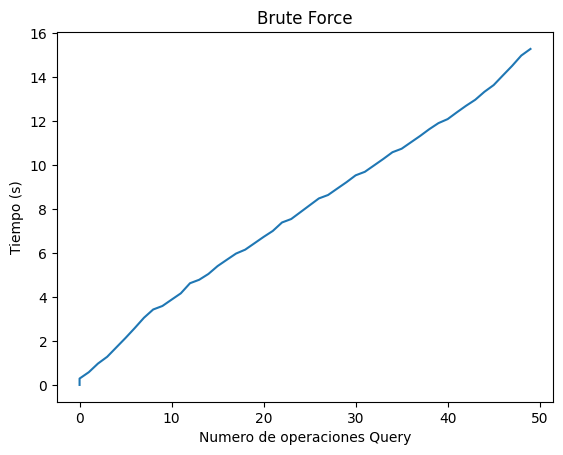

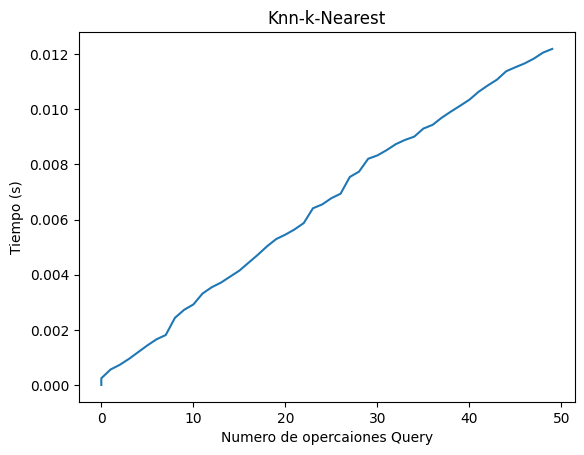

In [15]:
grafica_2d(x1, y1, "Numero de operaciones Query", "Tiempo (s)", "Brute Force")
grafica_2d(x2, y2, "Numero de opercaiones Query", "Tiempo (s)", "Knn-k-Nearest")

In [16]:
num_max_points = 1000000
points_2d = [Point([randint(0, 1000), randint(0, 1000)]) for _ in range(num_max_points)]
def get_time(points_2d, mediand_method):
  start_time = time.time()
  tree_2d = KdTreeChild(points_2d, median_method=mediand_method)
  return time.time() - start_time

print(f"Los tiempos en segundos es {get_time(points_2d, True)} de con las medias y {get_time(points_2d, False)} sin ellas")


Los tiempos en segundos es 18.67488932609558 de con las medias y 5.0772271156311035 sin ellas


Cuenta las distancias calculadas en:

Nube uniforme en
- [0,1]^{k}.
- Cluster gaussiano .

1. Cluster gaussiano tiene una distribucion normal, tiene una campana una mayor aglomeracion de puntos por lo que al realizar un ``kNearestNeighbors``, podriamos potencial mente visitar a los puntos dentro de la campana.
2.